In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor

sns.set(rc={"figure.dpi": 150, 'savefig.dpi': 150})
N_FOLD = 10

In [2]:
dataframe = pd.read_csv('data/four_feature_clean_.csv.gz', verbose=False)

In [4]:
x_features = ['DayOfTheWeek', 'MinuteOfTheDay', 'Latitude', 'Longitude']
y_feature = 'AvailableSpace'

x, y = dataframe[x_features], dataframe[y_feature]

# under-sampling
# from imblearn.under_sampling import RandomUnderSampler
# random_under_sampler = RandomUnderSampler()
# x, y = random_under_sampler.fit_resample(x, y)

print(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1 / 3, random_state=0)

     DayOfTheWeek  MinuteOfTheDay    Latitude  Longitude
0               2             870 -122.327130  47.608020
1               3             495 -122.336432  47.620935
2               4             848 -122.336669  47.625643
3               1             789 -122.337888  47.625642
4               0             637 -122.329366  47.627340
..            ...             ...         ...        ...
155             2             480 -122.318297  47.616969
156             5             480 -122.318297  47.616969
157             5             481 -122.318297  47.616969
158             3             480 -122.318297  47.616969
159             1             480 -122.318297  47.616969

[160 rows x 4 columns]


In [5]:
def plot_mse(plot_model, plot_x_train, plot_y_train, cv):
    score_results = cross_val_score(plot_model, plot_x_train, plot_y_train,
                                    cv=cv, scoring=make_scorer(mean_squared_error))
    score_series = pd.Series(score_results, name='MSE')
    score_df = pd.concat([score_series], axis=1)
    score_df['Fold'] = list(range(1, cv + 1))

    ax = sns.barplot(x="Fold", y="MSE", data=score_df)
    ax.set(xlabel='Fold', ylabel='Mean squared error')
    plt.show()


def plot_mae(plot_model, plot_x_train, plot_y_train, cv):
    score_results = cross_val_score(plot_model, plot_x_train, plot_y_train,
                                    cv=cv, scoring=make_scorer(mean_absolute_error))
    score_series = pd.Series(score_results, name='MAE')
    score_df = pd.concat([score_series], axis=1)
    score_df['Fold'] = list(range(1, cv + 1))

    ax = sns.barplot(x="Fold", y="MAE", data=score_df)
    ax.set(xlabel='Fold', ylabel='Mean absolute error')
    plt.show()


def plot_prediction(eval_model, eval_x_train, eval_y_train, eval_x_test, eval_y_test):
    eval_predicted = cross_val_predict(eval_model, eval_x_train, eval_y_train, cv=10)
    eval_y_predicted = eval_model.predict(eval_x_test)

    fig, ax = plt.subplots()
    ax.scatter(eval_y_train, eval_predicted, edgecolors=(0, 0, 0))
    ax.plot([eval_y_train.min(), eval_y_train.max()], [eval_y_train.min(), eval_y_train.max()], "k--", lw=4)
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    ax.annotate("r-squared = {:.3f}".format(r2_score(eval_y_test, eval_y_predicted)), (0, 1))
    plt.show()

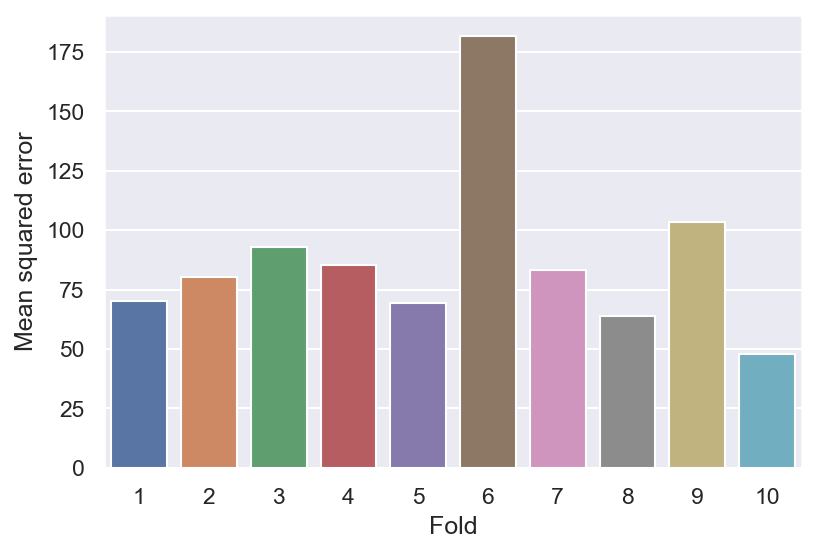

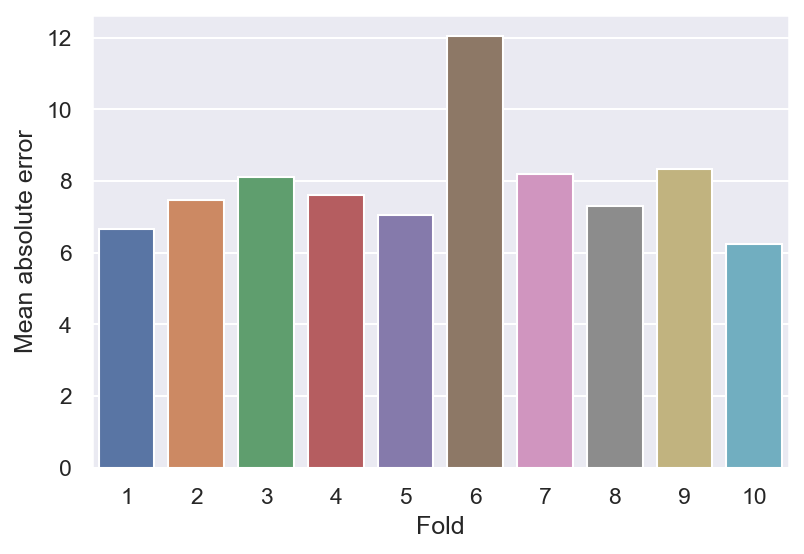

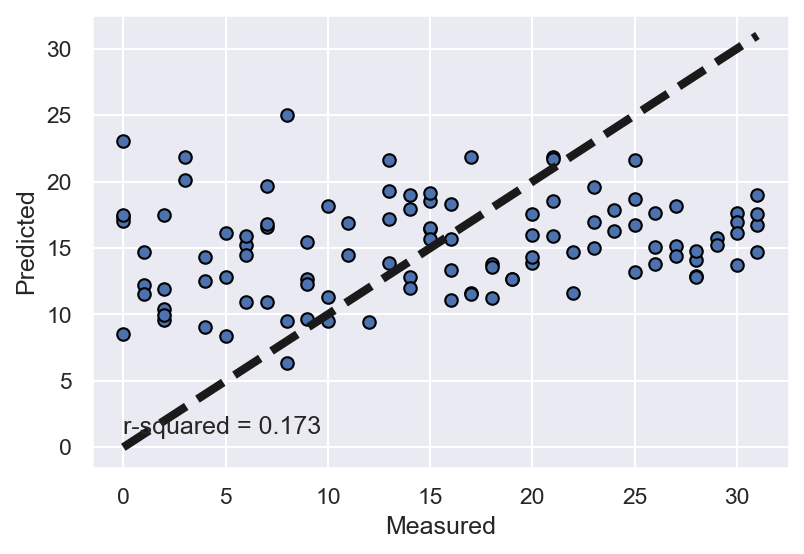

In [6]:
# linear
def linear(model_x_train, model_y_train, model_x_test, model_y_test):
    # model training
    train_model = LinearRegression()
    train_model.fit(model_x_train, model_y_train)

    # model evaluation
    model_y_predicted = train_model.predict(model_x_test)
    mae = mean_absolute_error(model_y_test, model_y_predicted)
    mse = mean_squared_error(model_y_test, model_y_predicted)
    r2 = r2_score(model_y_test, model_y_predicted)

    # plot
    plot_mse(train_model, model_x_train, model_y_train, N_FOLD)
    plot_mae(train_model, model_x_train, model_y_train, N_FOLD)
    plot_prediction(train_model, model_x_train, model_y_train, model_x_test, model_y_test)


linear(x_train, y_train, x_test, y_test)

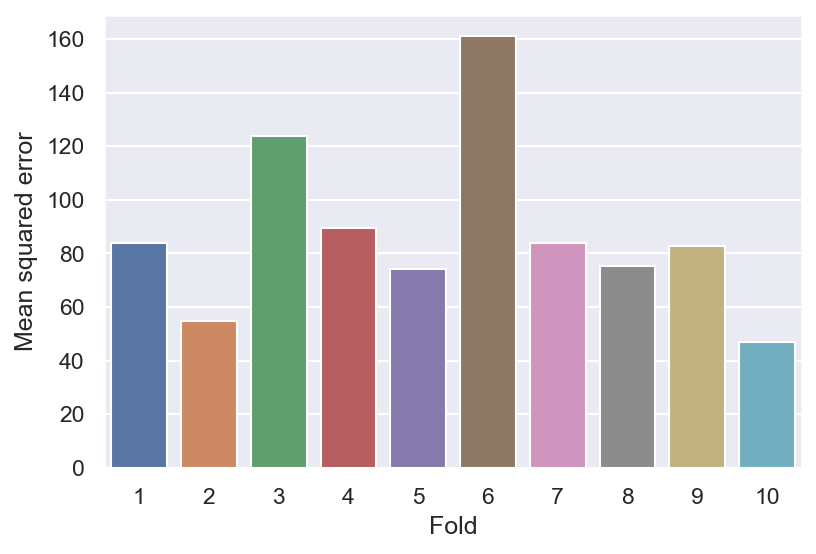

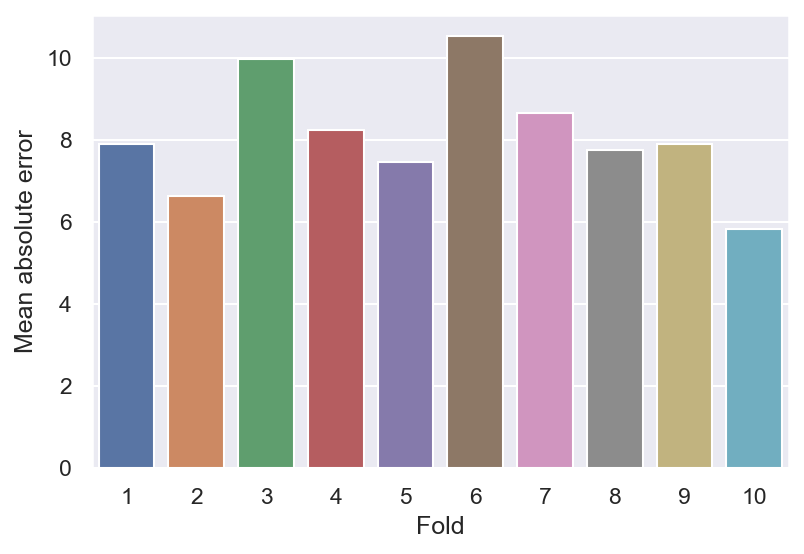

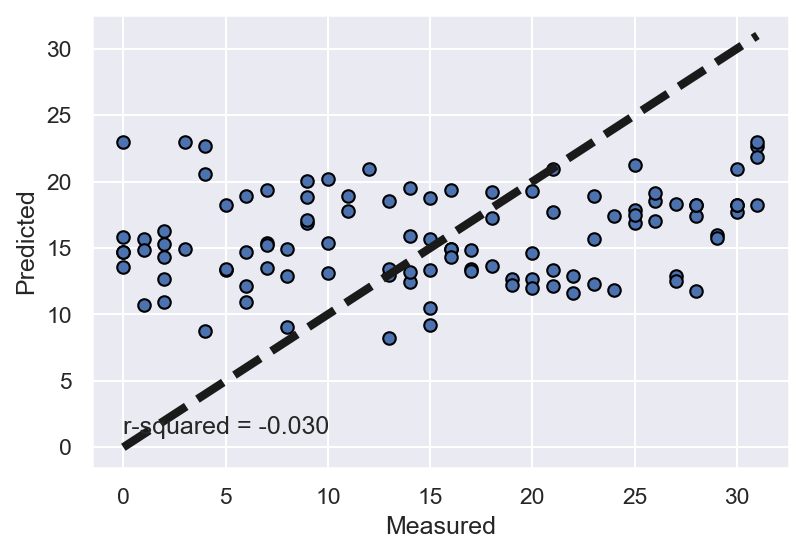

36 distance


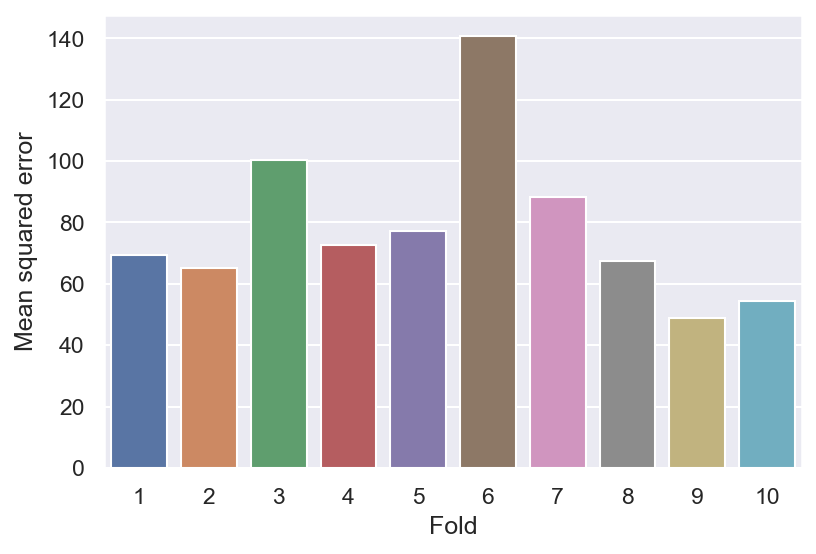

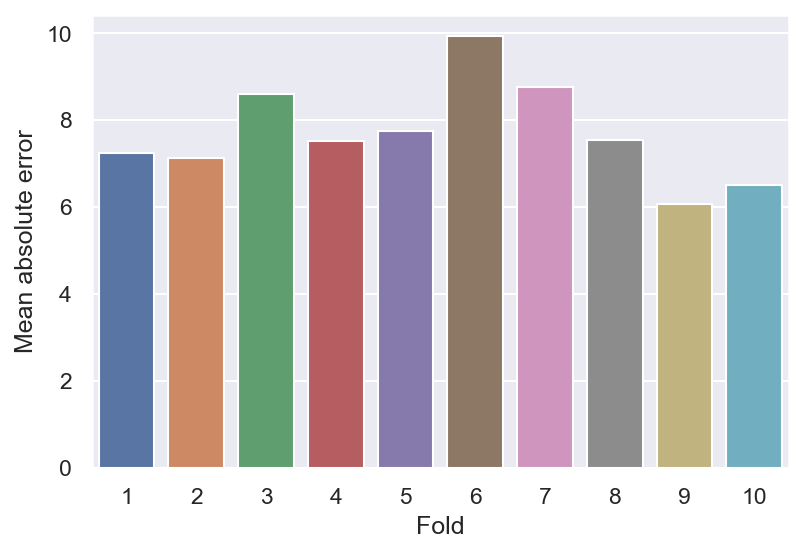

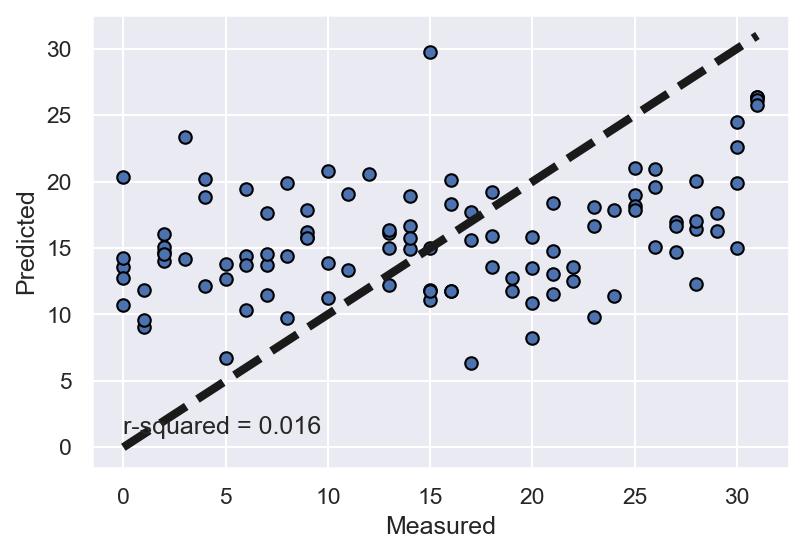

In [7]:
def knn(model_x_train, model_y_train, model_x_test, model_y_test):
    # model training
    train_model = KNeighborsRegressor(n_neighbors=14)
    train_model.fit(model_x_train, model_y_train)

    # model evaluation
    model_y_predicted = train_model.predict(model_x_test)
    mae = mean_absolute_error(model_y_test, model_y_predicted)
    mse = mean_squared_error(model_y_test, model_y_predicted)
    r2 = r2_score(model_y_test, model_y_predicted)

    # plot
    plot_mse(train_model, model_x_train, model_y_train, N_FOLD)
    plot_mae(train_model, model_x_train, model_y_train, N_FOLD)
    plot_prediction(train_model, model_x_train, model_y_train, model_x_test, model_y_test)

    # grid search
    train_model = KNeighborsRegressor()
    train_model_hyper_parameters = {
        'n_neighbors': list(range(1, 81)),
        'weights': ['uniform', 'distance']
    }

    grid_search = GridSearchCV(train_model, train_model_hyper_parameters, cv=N_FOLD, scoring='r2',
                               return_train_score=False)
    result = grid_search.fit(x_train, y_train)
    print(grid_search.best_params_['n_neighbors'], grid_search.best_params_['weights'])

    # model training with best params
    train_model = KNeighborsRegressor(n_neighbors=grid_search.best_params_['n_neighbors'],
                                      weights=grid_search.best_params_['weights'])
    train_model.fit(model_x_train, model_y_train)

    # model evaluation
    model_y_predicted = train_model.predict(model_x_test)
    mae = mean_absolute_error(model_y_test, model_y_predicted)
    mse = mean_squared_error(model_y_test, model_y_predicted)
    r2 = r2_score(model_y_test, model_y_predicted)

    # plot
    plot_mse(train_model, model_x_train, model_y_train, N_FOLD)
    plot_mae(train_model, model_x_train, model_y_train, N_FOLD)
    plot_prediction(train_model, model_x_train, model_y_train, model_x_test, model_y_test)


knn(x_train, y_train, x_test, y_test)

RandomForestRegressor R-Squared: 0.6555436443066516
MAE CV: [3.42545455 2.65590909 4.74409091 4.43727273 2.57772727 6.32636364
 6.0585     4.548      3.861      3.4605    ]
MSE CV: [26.17365455  8.60350682 36.57105227 29.84959091 11.19342045 74.6587
 65.4254375  33.3524175  23.8424     27.9711725 ]


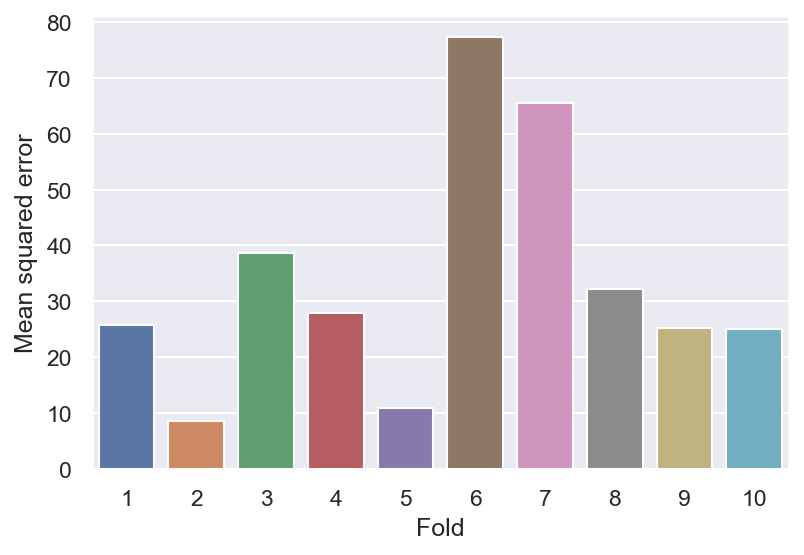

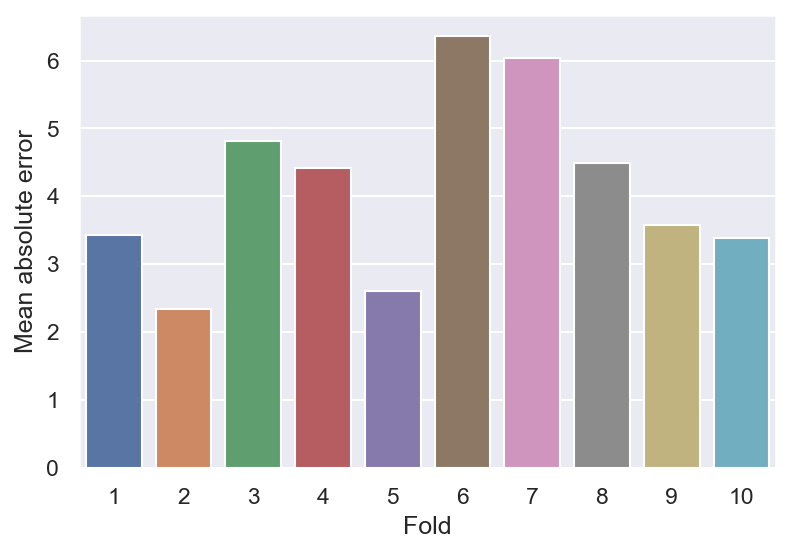

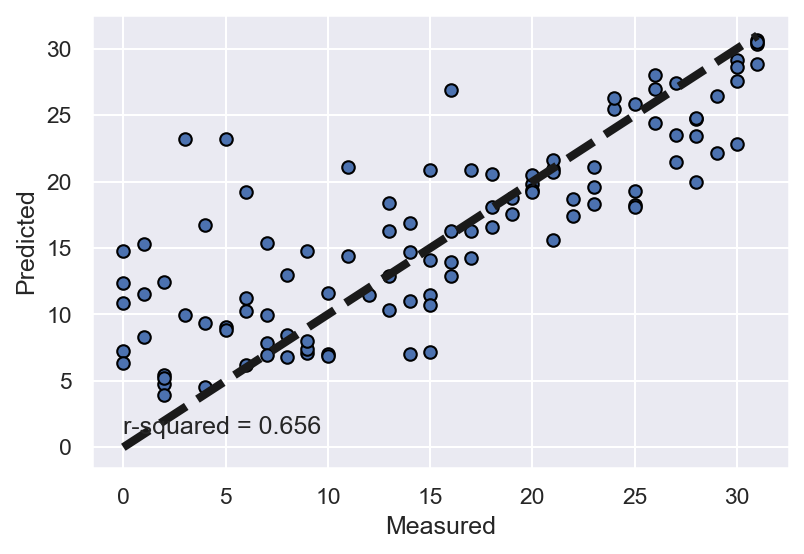

In [8]:
def random_forest(model_x_train, model_y_train, model_x_test, model_y_test):
    # model training
    train_model = RandomForestRegressor(n_estimators=200, max_depth=16, n_jobs=-1)
    train_model.fit(model_x_train, model_y_train)

    # model evaluation
    model_y_predicted = train_model.predict(model_x_test)
    mae = mean_absolute_error(model_y_test, model_y_predicted)
    mse = mean_squared_error(model_y_test, model_y_predicted)
    r2 = r2_score(model_y_test, model_y_predicted)

    print('{0} R-Squared: {1}'.format(train_model.__class__.__name__, r2))
    print('MAE CV:',
          cross_val_score(train_model, x_train, y_train, cv=N_FOLD, scoring=make_scorer(mean_absolute_error)))
    print('MSE CV:', cross_val_score(train_model, x_train, y_train, cv=N_FOLD, scoring=make_scorer(mean_squared_error)))

    # plot
    plot_mse(train_model, model_x_train, model_y_train, N_FOLD)
    plot_mae(train_model, model_x_train, model_y_train, N_FOLD)
    plot_prediction(train_model, model_x_train, model_y_train, model_x_test, model_y_test)


random_forest(x_train, y_train, x_test, y_test)

RandomForestRegressor R-Squared: 0.6462490014495088
MAE CV: [3.72363636 2.75181818 4.62727273 4.30909091 2.62818182 6.28818182
 6.266      4.502      3.863      3.279     ]
MSE CV: [24.83317273 10.5903     35.20787273 28.20683636 10.61590909 83.55148182
 68.24412    35.42074    23.24856    28.02067   ]


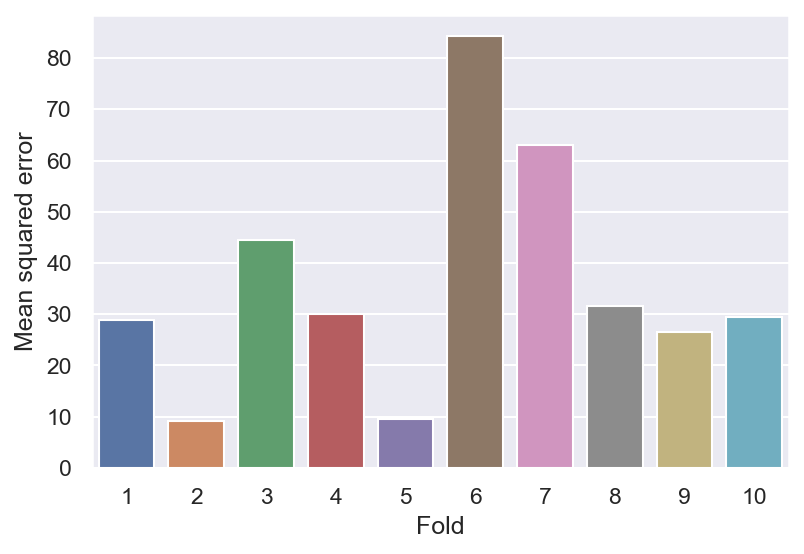

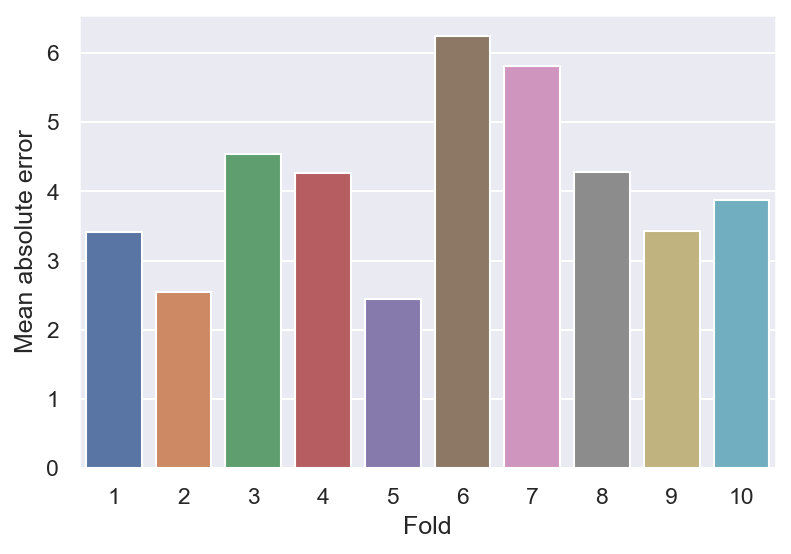

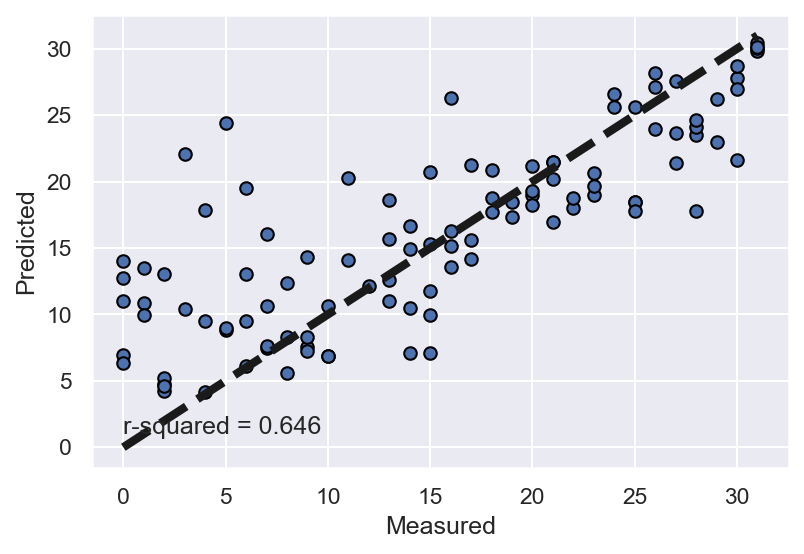

RandomForestRegressor R-Squared: 0.6582817898749127
MAE CV: [3.35545455 2.69090909 4.94545455 4.55090909 2.36454545 6.21090909
 6.4607     4.59       3.87341667 3.21033333]
MSE CV: [23.48022102  7.85045682 37.00374949 28.10065751 10.45432726 76.93612727
 59.3667584  29.88138111 20.17763    25.74324778]


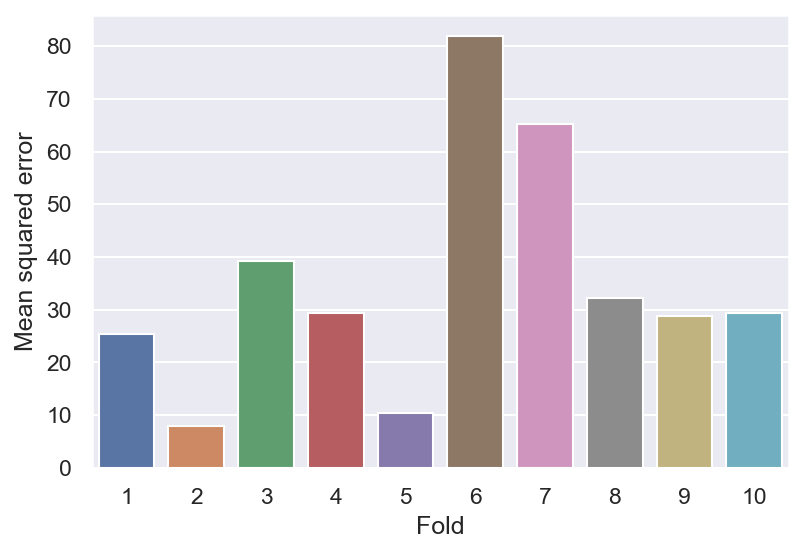

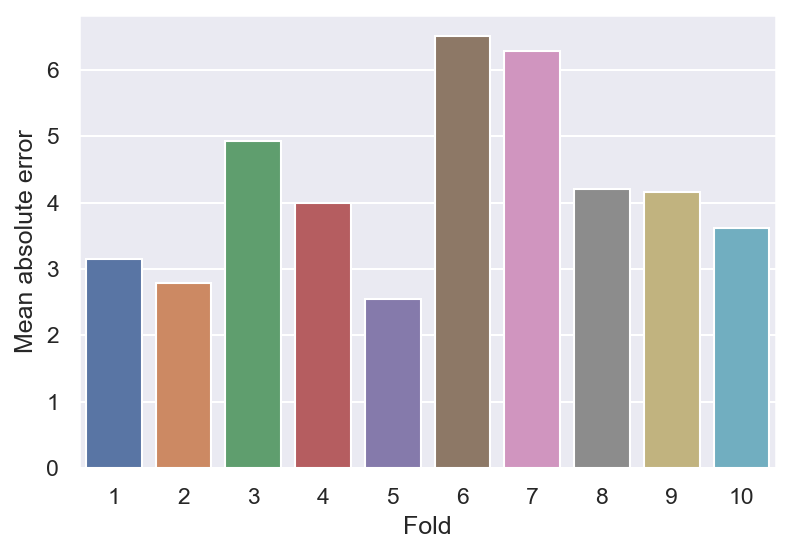

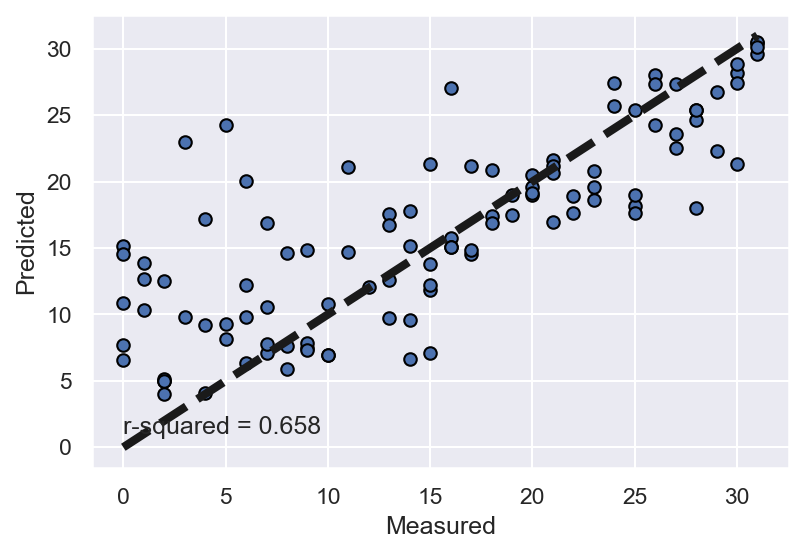

In [9]:
def random_forest_tuning(model_x_train, model_y_train, model_x_test, model_y_test):
    # grid search & model training
    train_model = RandomForestRegressor(n_jobs=-1)
    train_model_hyper_parameters = {'n_estimators': list(range(50, 400, 50))}
    grid_search = GridSearchCV(train_model, train_model_hyper_parameters, cv=N_FOLD, scoring='r2',
                               return_train_score=False)
    grid_search.fit(x_train, y_train)

    best_n_estimators = grid_search.best_params_['n_estimators']
    train_model = RandomForestRegressor(n_estimators=best_n_estimators, n_jobs=-1)
    train_model.fit(x_train, y_train)

    # model evaluation
    model_y_predicted = train_model.predict(model_x_test)
    mae = mean_absolute_error(model_y_test, model_y_predicted)
    mse = mean_squared_error(model_y_test, model_y_predicted)
    r2 = r2_score(model_y_test, model_y_predicted)

    print('{0} R-Squared: {1}'.format(train_model.__class__.__name__, r2))
    print('MAE CV:',
          cross_val_score(train_model, x_train, y_train, cv=N_FOLD, scoring=make_scorer(mean_absolute_error)))
    print('MSE CV:', cross_val_score(train_model, x_train, y_train, cv=N_FOLD, scoring=make_scorer(mean_squared_error)))

    # plot
    plot_mse(train_model, model_x_train, model_y_train, N_FOLD)
    plot_mae(train_model, model_x_train, model_y_train, N_FOLD)
    plot_prediction(train_model, model_x_train, model_y_train, model_x_test, model_y_test)

    # grid search & model training
    train_model = RandomForestRegressor(n_jobs=-1)
    train_model_hyper_parameters = {'max_depth': range(10, 21)}
    grid_search = GridSearchCV(train_model, train_model_hyper_parameters, cv=N_FOLD, scoring='r2',
                               return_train_score=False)
    grid_search.fit(x_train, y_train)

    best_max_depth = grid_search.best_params_['max_depth']
    train_model = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth, n_jobs=-1)
    train_model.fit(x_train, y_train)

    # model evaluation
    model_y_predicted = train_model.predict(model_x_test)
    mae = mean_absolute_error(model_y_test, model_y_predicted)
    mse = mean_squared_error(model_y_test, model_y_predicted)
    r2 = r2_score(model_y_test, model_y_predicted)

    print('{0} R-Squared: {1}'.format(train_model.__class__.__name__, r2))
    print('MAE CV:',
          cross_val_score(train_model, x_train, y_train, cv=N_FOLD, scoring=make_scorer(mean_absolute_error)))
    print('MSE CV:', cross_val_score(train_model, x_train, y_train, cv=N_FOLD, scoring=make_scorer(mean_squared_error)))

    # plot
    plot_mse(train_model, model_x_train, model_y_train, N_FOLD)
    plot_mae(train_model, model_x_train, model_y_train, N_FOLD)
    plot_prediction(train_model, model_x_train, model_y_train, model_x_test, model_y_test)


random_forest_tuning(x_train, y_train, x_test, y_test)